In [2]:
#Reload changes -> always run this
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 9.1: MRJob Implementation of Basic PageRank

Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:

A,0.033

B,0.384

C,0.343

D,0.039

E,0.081

F,0.039

G,0.016

H,0.016

I,0.016

J,0.016

K,0.016


In [49]:
%%writefile numberNodesMR.py

from mrjob.job import MRJob
from mrjob.step import MRStep

#this job calculates the number of nodes in a network, including dangling nodes. Used as input to other jobs
class NumberNodes(MRJob):
    
    def mapper1(self, _, line):
        newLine = line.split('\t') #split input line
        
        node = newLine[0]
        neighbors = eval(newLine[1]) #use eval to make sure dictionary is preserved 
        yield node, 1 #yield original node
        for neighbor in neighbors.keys():
            yield neighbor, 1 #get all neighbors
    
    def reducer1(self, key, values):
        yield key, 1
    
    def mapper2(self, key, values):
        yield None, 1 #don't care about nodes or neighbors anymore
    
    def reducer2(self, key, values):
        total = sum(values) #sum results
        yield None, total
    
        
    def steps(self):
        return [MRStep(mapper = self.mapper1, reducer = self.reducer1),
               MRStep(mapper = self.mapper2, reducer = self.reducer2)]
    
if __name__ == "__main__":
    NumberNodes.run()

Writing numberNodesMR.py


In [3]:
from numberNodesMR import NumberNodes

filename = 'PageRank-test.txt' #using for testing

mr_job = NumberNodes(args = [filename])

with mr_job.make_runner() as runner:
    runner.run()
    print "Number of nodes in " + filename
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)[1]

Number of nodes in PageRank-test.txt
11


In [17]:
%%writefile initPR.py

from mrjob.job import MRJob
from mrjob.step import MRStep

#this job will initialize a text file graph so it can be used for the next series of jobs
class InitPRJob(MRJob):
    
    def configure_options(self):
        super(InitPRJob, self).configure_options()
        #pass number of nodes as an argument
        self.add_passthrough_option('--numNodes', type = float, default = 10, help = 'Number of Nodes in Graph')
    
    
    def mapper(self, _, line):
        
        line = line.split('\t') #split input
        node = line[0]
        adj = eval(line[1]) #eval here to get dictionary
        for neighbor in adj.keys():
            yield neighbor, {} #yield an empty dictionary for all neighbors
        yield node, adj #get original
            
    
    def reducer(self, key, values):
        nid = key
        adj = {}
        dangling = True
        newValues = [value for value in values] #unpack values to a list
        for dictionary in newValues:
            if len(dictionary) != 0:
                adj = dictionary #set adjacency list if not a dangling node
        
        PageRank = float(1)/self.options.numNodes #calculate starting pagerank, 1/numberNodes
        
        yield nid, (PageRank, adj)

    def steps(self):
        return [
            MRStep(mapper = self.mapper, reducer = self.reducer)
        ]

if __name__ == "__main__":
    InitPRJob.run()

Overwriting initPR.py


In [5]:
from initPR import InitPRJob

mr_job = InitPRJob(args = ['PageRank-test.txt', '--numNodes', '11'])

with open('initData.txt', 'w+') as myfile: #this file will be used as input for the next series of jobs
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            myfile.write(line)

In [11]:
%%writefile pageRank.py

from mrjob.job import MRJob
from mrjob.step import MRStep

#calculate one iteration of pageRank
class PageRankMR(MRJob):
    
    def configure_options(self):
        super(PageRankMR, self).configure_options()
        self.add_passthrough_option('--alpha', type = float, default = 0.15, help = "Alpha") #alpha
        self.add_passthrough_option('--numNodes', type = int, default = 10, help = 'Number Nodes') #number of Nodes 
    
    def mapper1(self, _, line):
        data = line.split('\t')
        nid = eval(data[0]) #evaluate the node id which is a string
        data2 = eval(data[1]) #Structure is (PageRank, neighbors)
        curPr = float(data2[0]) #convert to float
        neighbors = data2[1]
        
        yield nid, neighbors #yield original node and neighbors to preserve structure
        
        if len(neighbors) == 0:
            yield '*', curPr #we are at a dangling node
        else:
            newPR = curPr/len(neighbors) #new pagerank based on the number of neighbors
            for nid in neighbors.keys():
                yield nid, newPR #yield neighbor and pagerank
                
    def reducer_init(self):
        self.mass = 0 #stores the dangling mass
    
    def reducer1(self, key, values):
        if key == '*':
            for value in values:
                curPr = value
                self.mass += curPr #increment dangling mass
        else:
            newPr = float(0) #new pageRank
            adj = {} #neighbors
            
            for value in values:
                if type(value) == dict:
                    adj = value #our node has neighbors so set the neighbors dict
                else:
                    newPr += value #we're at a pagerank value so increment the new pagerank
           
            yield key, (newPr, adj) #yield results
    
                
    def reducer_final(self):
        yield '*', self.mass #pass dangling mass to be distributed later
        
    def reducer2_init(self):
        self.mass = 0.0 #initialize, probably a more efficient way to deal with this
      
    def reducer2(self, key, values):
        nid = key
        if nid == '*': #pass mass along here
            for value in values:
                self.mass += value #if we've gotten dangling mass increment its value here
        else:
            valList = [value for value in values][0] #unpack incoming values, (pageRank, neighbors)
            curPr = float(valList[0]) #set variables
            neighbors = valList[1]
            
            newMass = self.mass/self.options.numNodes #new mass distributed among all nodes
            alpha = self.options.alpha
            
            newPr = (alpha/float(self.options.numNodes)) + ((1-alpha) * float(newMass + curPr)) #final pagerank
        
            yield nid, (newPr, neighbors)
        
    def steps(self):
        return [
            MRStep(mapper = self.mapper1, 
                   reducer_init = self.reducer_init, 
                   reducer = self.reducer1, 
                   reducer_final = self.reducer_final),
            MRStep(reducer_init = self.reducer2_init, reducer = self.reducer2)
        ]
        
if __name__ == "__main__":
    PageRankMR.run()

Overwriting pageRank.py


In [12]:
from pageRank import PageRankMR

#This just runs one iteration to check our output

mr_job = PageRankMR(args = ['initData.txt', '--alpha', '0.15', '--numNodes', '11'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

('A', [0.059297520661157024, {}])
('B', [0.3168732782369146, {'C': 1}])
('C', [0.09793388429752066, {'B': 1}])
('D', [0.046418732782369146, {'A': 1, 'B': 1}])
('E', [0.32975206611570246, {'B': 1, 'D': 1, 'F': 1}])
('F', [0.046418732782369146, {'B': 1, 'E': 1}])
('G', [0.02066115702479339, {'B': 1, 'E': 1}])
('H', [0.02066115702479339, {'B': 1, 'E': 1}])
('I', [0.02066115702479339, {'B': 1, 'E': 1}])
('J', [0.02066115702479339, {'E': 1}])
('K', [0.02066115702479339, {'E': 1}])


In [13]:
from initPR import InitPRJob
from pageRank import PageRankMR
import os

#Driver for controlling all phases from initiation to iteration

# mr_job_init = InitPRJob(args = ['PageRank-test.txt'])
# with open('initData.txt', 'w+') as myfile:
#     with mr_job_init.make_runner() as runner:
#         runner.run()
#         for line in runner.stream_output():
#             myfile.write(line)

iteration = 0

while(iteration < 40): #set iteration
    if iteration == 0: #if on 0 iteration take the input file and produce the intermediate results
        with open('interResults.txt', 'w+') as myfile:
            mr_job = PageRankMR(args = ['initData.txt', '--alpha', '0.15', '--numNodes', '11'])
            with mr_job.make_runner() as runner:
                runner.run()
                for line in runner.stream_output():
                    myfile.write(line)
        iteration += 1
    else: #otherwise we're on an iteration and run
        with open('newFile.txt', 'w+') as myfile:
            mr_job = PageRankMR(args = ['interResults.txt', '--alpha', '0.15', '--numNodes', '11'])
            with mr_job.make_runner() as runner:
                runner.run()
                for line in runner.stream_output():
                    myfile.write(line)
        iteration += 1
        os.rename('newFile.txt', 'interResults.txt')
        
print "All done"       

#Would probably want a more formal definition of convergence. 


All done


## HW 9.2: Exploring PageRank teleportation and network plots

In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. Note your plots should look like the following:

Factors:
0

0.25

0.5

0.75

0.85

1

https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg


In [1]:
from pageRank import PageRankMR

#Create list of teleportation factors, which are 1-the dampening factor provided to work with our code
d = [1, 0.75, 0.5, 0.25, 0.15, 0]

for damp in d: #generate output files to use for input, we are only using one iteration
    with open('output' + str(damp) + '.txt', 'w+') as myfile:
        mr_job = PageRankMR(args = ['initData.txt', '--alpha', str(damp), '--numNodes', '11'])
        with mr_job.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                myfile.write(line)

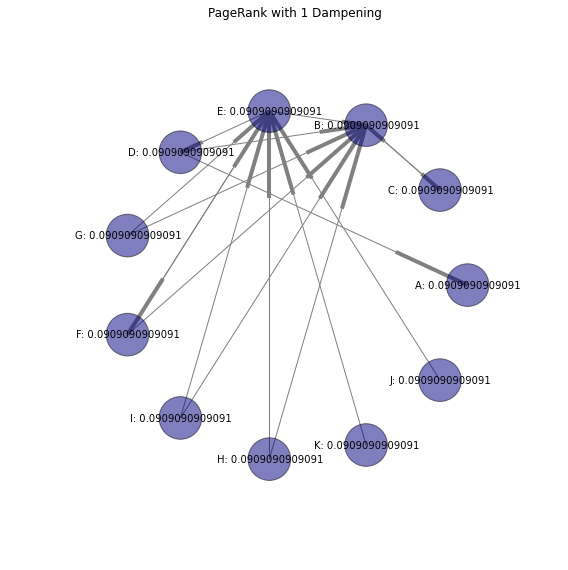

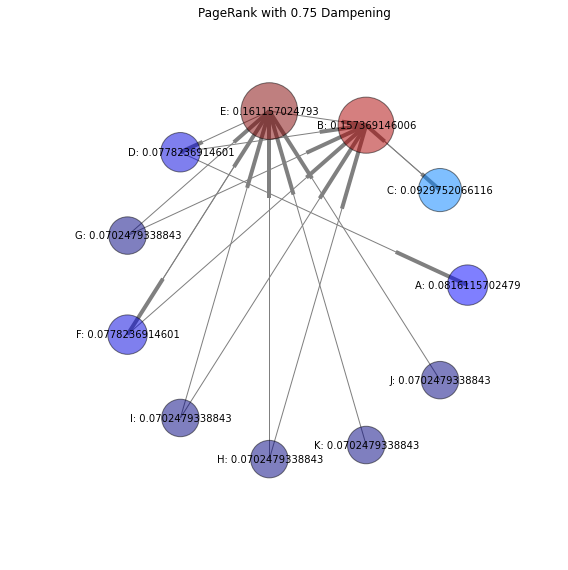

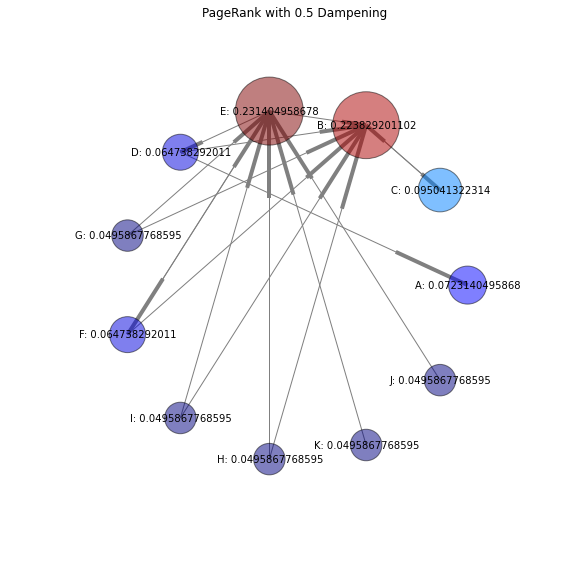

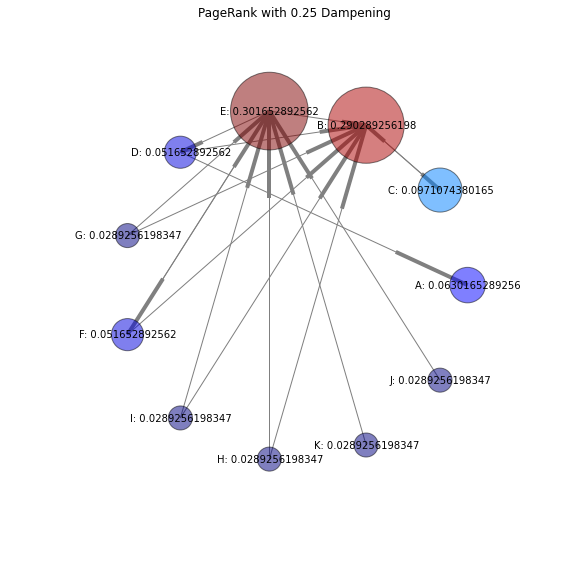

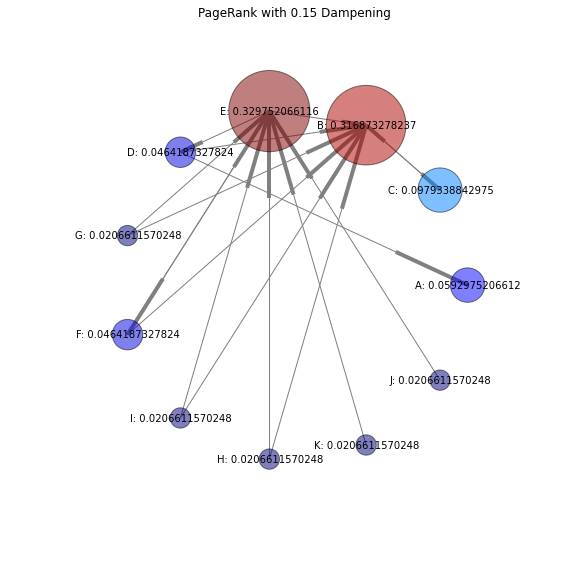

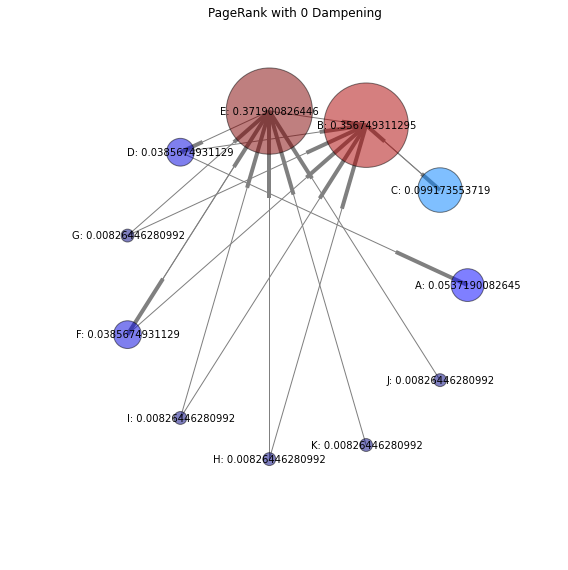

In [2]:
%matplotlib inline
import networkx as nx
from matplotlib import pyplot as plt

def draw(inputFile, d):
    edges = [] #variables to hold our results
    pr = {}
    
    with open(inputFile, 'r') as myfile:
        lines = myfile.readlines()
        for line in lines:
            data = line.split('\t') #split and grab data
            nid = eval(data[0]) #evaluate string
            
            data2 = eval(data[1]) #evaluate (PageRank, neighbors)
            curPr = float(data2[0])
            neighbors = data2[1]
            
            for neighbor in neighbors.keys():
                edges.append((nid, neighbor)) #append edges between nodes and neighbors
                
            pr[nid] = curPr #add pagerank
            
    #Have now gotten all the inputs needed for the graph
    
    plt.figure(figsize = (8,8))
    DG = nx.DiGraph()
    
    for edge in edges:
        DG.add_edge(edge[0], edge[1]) #draw an edge
    
    node_size = [pr[node] * 20000 for node in DG.nodes()] #set size of nodes
    graph_pos = nx.circular_layout(DG) #use circular layout
    
    labels = {}
    for node in DG.nodes():
        labels[node] = node + ': ' + str(pr[node]) #add node ID and pagerank as label
        
    
    nx.draw_networkx_nodes(DG, graph_pos, node_size = node_size, node_color = node_size, alpha = 0.5) #graph
    nx.draw_networkx_edges(DG, graph_pos, edge_color = 'grey', arrows = True)
    nx.draw_networkx_labels(DG, graph_pos, labels = labels, font_size = 10)
    
    plt.title("PageRank with " + str(d) + " Dampening") #check
    plt.axis('off')
    plt.tight_layout()
    plt.show()

for damp in d:
    draw('output' + str(damp) + '.txt', damp)

## HW 9.3: Applying PageRank to the Wikipedia hyperlinks network

Run your PageRank implementation on the Wikipedia dataset for 5 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Have the top 100 ranked pages changed? Comment on your findings. Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  


In [3]:
%%writefile danglingpagerank.py

from mrjob.job import MRJob
from mrjob.step import MRStep

class DanglingPageRankJob(MRJob):
    
    def mapper(self, _, line):
        data = line.split('\t')
        nid = eval(data[0])
        data2 = eval(data[1])
        curPr = float(data2[0])
        neighbors = data2[1]
        
        if len(neighbors) == 0:
            yield '*', curPr
    
    def reducer(self, key, values):
        total = sum(values)
        yield 'mass', total
    
if __name__ == '__main__':
    DanglingPageRankJob.run()

Writing danglingpagerank.py


In [5]:
from danglingpagerank import DanglingPageRankJob

mr_job = DanglingPageRankJob(args = ['initData.txt'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print line

"mass"	0.09090909090909091



In [3]:
%%writefile pageRank2.py

from mrjob.job import MRJob
from mrjob.step import MRStep
from operator import itemgetter

class PageRankMR2(MRJob):
    
    def configure_options(self):
        super(PageRankMR2, self).configure_options()
        self.add_passthrough_option('--alpha', type = float, default = 0.15, help = 'Alpha/Teleportation')
        self.add_passthrough_option('--numNodes', type = int, default = 10, help = 'Number of Nodes')
        self.add_passthrough_option('--mass', type = float, default = 0.0, help = 'Mass from Dangling Nodes')
        
    def mapper1(self, _, line):
        data = line.split('\t')
        nid = eval(data[0])
        
        data2 = eval(data[1])
        curPr = float(data2[0])
        neighbors = data2[1]
        
        yield nid, neighbors
        
        if len(neighbors) == 0:
            pass
        else:
            newPr = curPr/len(neighbors)
            for nid in neighbors.keys():
                yield nid, newPr
            
    def reducer1(self, key, values):
        newPr = float(0)
        adj = {}
        
        for value in values:
            if type(value) == dict:
                adj = value
            else:
                newPr += value
                
        newMass = self.options.mass/self.options.numNodes
        alpha = self.options.alpha
        
        finalPr = (alpha/float(self.options.numNodes)) + ((1-alpha) * float(newMass + newPr))
    
        yield key, (finalPr, adj)
        
       
        
    def steps(self):
        
        return [MRStep(mapper = self.mapper1, reducer = self.reducer1)]
              
        

if __name__ == '__main__':
    PageRankMR2.run()

Overwriting pageRank2.py


In [3]:
%%writefile topRank.py

from mrjob.job import MRJob
from mrjob.step import MRStep
from operator import itemgetter

class TopRankJob(MRJob):
    
    def configure_options(self):
        super(TopRankJob, self).configure_options()
        self.add_passthrough_option('--N', type = int, default = 10, help = 'Number of top ranked to keep')
        
    def mapper_sort(self, _, line):
        data = line.split('\t')
        node = eval(data[0])
        
        data2 = eval(data[1])
        pageRank = data2[0]
        
        if pageRank < 0.00001:
            pass
        else:
            yield None, (node, pageRank)
            

    def reducer_sort(self, _, values):
        sortedList = []
        for node, score in values:
            sortedList.append((node, score))
            sortedList = sorted(sortedList, key = itemgetter(1), reverse = True)
            
            if len(sortedList) > self.options.N:
                sortedList.pop()
                
        for node, score in sortedList: 
               yield node, score
    
     
            
    def steps(self):
        return [MRStep(mapper = self.mapper_sort, reducer = self.reducer_sort)]
    
if __name__ == '__main__':
    TopRankJob.run()

Overwriting topRank.py


In [14]:
from danglingpagerank import DanglingPageRankJob
from pageRank2 import PageRankMR2
from topRank import TopRankJob
import os

iteration = 1

while iteration <= 10:
    if iteration == 1:
        curMass = 0.0

        mr_job_dangling = DanglingPageRankJob(args = ['initData.txt'])

        with mr_job_dangling.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                result = mr_job_dangling.parse_output_line(line)
                curMass += result[1]

        mr_job = PageRankMR2(args = ['initData.txt', '--numNodes', '11', '--mass', str(curMass)])

        with open('interResults' + str(iteration) + '.txt', 'w+') as myfile:
            with mr_job.make_runner() as runner:
                runner.run()
                for line in runner.stream_output():
                    myfile.write(line)
            
      
        iteration +=1
    else:
        curMass = 0.0
        
        mr_job_dangling = DanglingPageRankJob(args = ['interResults' + str(iteration - 1) + '.txt'])
        with mr_job_dangling.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                result = mr_job_dangling.parse_output_line(line)
                curMass += result[1]
                
        mr_job = PageRankMR2(args = ['interResults' + str(iteration -1) + '.txt', 
                                     '--numNodes', '11', '--mass', str(curMass)])
        
        with open('interResults' + str(iteration) + '.txt', 'w+') as myfile:
            with mr_job.make_runner() as runner:
                runner.run()
                for line in runner.stream_output():
                    myfile.write(line)
        iteration += 1
        
mr_job_rank = TopRankJob(args = ['interResults' + str(iteration-1) + '.txt', '--N', '3'])
with mr_job_rank.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job_rank.parse_output_line(line)
        
        
for i in range(1,11):
    os.remove('interResults' + str(i) + '.txt')
        
#           mr_job_rank = TopRankJob(args = ['interResults' + str(iteration) + '.txt', '--N', '3'])
#         with mr_job_rank.make_runner() as runner:
#             runner.run()
#             for line in runner.stream_output():
#                 print mr_job_rank.parse_output_line(line)



('B', 0.36323594898893996)
('C', 0.36288372803873453)
('E', 0.08114525762550133)


In [3]:
!python -m mrjob.tools.emr.create_job_flow '--conf-path' 'mrjob.conf'

creating new scratch bucket mrjob-f3522a9f2dabe25e
using s3://mrjob-f3522a9f2dabe25e/tmp/ as our scratch dir on S3
Creating persistent job flow to run several jobs in...
creating tmp directory /var/folders/tx/cr7tg62d7rdd750f_czjczfm0000gn/T/no_script.dunmireg.20160318.190133.469512
writing master bootstrap script to /var/folders/tx/cr7tg62d7rdd750f_czjczfm0000gn/T/no_script.dunmireg.20160318.190133.469512/b.py
creating S3 bucket 'mrjob-f3522a9f2dabe25e' to use as scratch space
Copying non-input files into s3://mrjob-f3522a9f2dabe25e/tmp/no_script.dunmireg.20160318.190133.469512/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-3BZDNDD1NP99F
j-3BZDNDD1NP99F


In [7]:
from danglingpagerank import DanglingPageRankJob
from pageRank2 import PageRankMR2
from topRank import TopRankJob
import os

iteration = 1
clusterID = 'j-3BZDNDD1NP99F'

# while iteration <= 5:
#     if iteration == 1:
#         curMass = 0.0
#         mr_job_dangling = DanglingPageRankJob(args = ['s3://dunmireg/HW9/wikiInput/', '-r', 'emr',
#                                                      '--no-strict-protocols', 
#                                                      '--emr-job-flow-id', clusterID])

#         with mr_job_dangling.make_runner() as runner:
#             runner.run()
#             for line in runner.stream_output():
#                 result = mr_job_dangling.parse_output_line(line)
#                 curMass += float(result[1])

#         mr_job = PageRankMR2(args = ['s3://dunmireg/HW9/wikiInput/', '--numNodes', '15192277', '--mass', str(curMass),
#                                     '--no-strict-protocols', '-r', 'emr',
#                                     '--emr-job-flow-id', clusterID,
#                                     '--output-dir', 's3://dunmireg/HW9/output' + str(iteration)])
        
#         with mr_job.make_runner() as runner:
#             runner.run()
            
#         print 'Done Iteration 1'
#         iteration +=1
#     else:
#         curMass = 0.0
        
#         mr_job_dangling = DanglingPageRankJob(args = ['s3://dunmireg/HW9/output' + str(iteration-1) + '/', 
#                                                       '-r', 'emr',
#                                                      '--no-strict-protocols', 
#                                                      '--emr-job-flow-id', clusterID])
#         with mr_job_dangling.make_runner() as runner:
#             runner.run()
#             for line in runner.stream_output():
#                 result = mr_job_dangling.parse_output_line(line)
#                 curMass += float(result[1])
                
#         mr_job = PageRankMR2(args = ['s3://dunmireg/HW9/output' + str(iteration - 1) + '/', 
#                                      '--numNodes', '15192277', '--mass', str(curMass),
#                                     '-r', 'emr',
#                                     '--emr-job-flow-id', clusterID,
#                                     '--output-dir', 's3://dunmireg/HW9/output' + str(iteration)])
        
#         with mr_job.make_runner() as runner:
#             runner.run()
        
       
        
        
#         print 'Done with Iteration ' + str(iteration)
#         iteration += 1
        
mr_job_rank = TopRankJob(args = ['s3://dunmireg/HW9/output' + str(iteration-1) + '/', '--N', '100',
                                '-r', 'emr',
                                '--emr-job-flow-id', clusterID,
                                '--output-dir', 's3://dunmireg/HW9/outputDone'])
with open('5iterations.txt', 'w+') as myfile:  
    with mr_job_rank.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            myfile.write(line)
        



None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [10]:
%%writefile join.py

from mrjob.job import MRJob

class JoinJob(MRJob):
    
    def mapper_init(self):
        self.webIDs = {}
        with open('5iterations.txt', 'r') as myfile:
            lines = myfile.readlines()
            for line in lines:
                line = line.split('\t')
                node = eval(line[0])
                self.webIDs[node] = line[1].strip()
            print self.webIDs
                
    def mapper(self, _, line):
        line = line.strip().split('\t')
        if str(line[1]) in self.webIDs.keys():
            yield self.webIDs[str(line[1])], line[0]

if __name__ == "__main__":
    JoinJob.run()

Overwriting join.py


In [11]:
from join import JoinJob

mr_job = JoinJob(args = ['indices.txt', '--file', '5iterations.txt'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

{'3191491': '0.00034494996984198607', '4624519': '0.00014402907240713964', '6113490': '0.0004547314775677173', '2437837': '0.00044562508250769529', '13853369': '0.00011740864240832358', '3591832': '0.00011331511738023241', '9997298': '0.00015899172680111583', '6076759': '0.00043040419620364996', '6416278': '0.00033109095769617543', '5490435': '0.00018010854060497548', '12038331': '0.00014173675937141533', '1637982': '0.00021244404524157508', '9924814': '0.00012078671805253393', '994890': '0.00016773063851468695', '13425865': '0.00042865182357834436', '6237129': '0.00032801716164861252', '9276255': '0.00031265952242051301', '1523975': '0.00013604032850342523', '9394907': '0.00016069552457103012', '1813634': '0.00012623633337781979', '2778099': '0.00012249989411475075', '3603527': '0.00026001491125847339', '5051368': '0.00057637936353319727', '6172167': '0.00019154168808024899', '3069099': '0.00025351065950211219', '15164193': '0.00035013370050190586', '4568647': '0.00011638987005226357'

In [ ]:
#To run on AWS use the following command:
#change the .py file and input and output directories to match the job
# python numberNodesMR.py -r emr \
# s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \ 
# --conf-path mrjob.conf \
# --output-dir=s3://dunmireg/HW9/wiki \ 
# --no-output \
# --no-strict-protocol

15,192,277 Nodes

In [ ]:
# python initPr.py -r emr \
# s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \
# --numNodes 15192277 \
# --conf-path mrjob.conf \
# --output-dir=s3://dunmireg/HW9/wikiInput \
# --no-output
# --no-strict-protocol


## HW 9.4: Topic-specific PageRank implementation using MRJob

Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the following randomly generated network of 100 nodes:

s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:

vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj

for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes.
If beta > 0.5, PageRank is topic-sensitive, 
and if beta < 0.5, the PageRank is anti-topic-sensitive. 
For any value of beta irreducibility should hold,
so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.


In [3]:
#Grab number of nodes
from numberNodesMR import NumberNodes

filename = 'randNet.txt'

mr_job = NumberNodes(args = [filename])

with mr_job.make_runner() as runner:
    runner.run()
    print "Number of nodes in " + filename
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)[1]

Number of nodes in randNet.txt
100


if the node is in the topic:

$\beta * \frac{1}{|Tj|}$

else

$(1-\beta) * (\frac{1}{N - |Tj|})$

In [6]:
%%writefile initTopic.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class initTopicJob(MRJob):
    
    def configure_options(self):
        super(initTopicJob, self).configure_options()
        self.add_passthrough_option('--numNodes', type = float, default = 100.0, help = 'Number of Nodes')
        self.add_passthrough_option('--topic', type = int, default = 1, help = 'Topic')
        self.add_passthrough_option('--beta', type = float, default = 0.99, help = 'Beta')
    
    
    
    def mapper(self, _, line):
        line = line.split('\t')
        node = line[0]
        adj = eval(line[1])
        for neighbor in adj.keys():
            yield neighbor, {}
        yield node, adj
        
        
 
        
    def reducer_init(self):
        self.nodeList = []
        self.topicNum = 0
        with open('randNet_topics.txt', 'r') as myfile:
            for line in myfile.readlines():
                data = line.split('\t')
                node = str(data[0])
                curTopic = int(data[1])
                if curTopic == self.options.topic:
                    self.nodeList.append(node)
                    self.topicNum += 1
                    
                    
    
    def reducer(self, key, values):
        nid = key
        adj = {}
        newValues = [value for value in values]
        for dictionary in newValues:
            if len(dictionary) != 0:
                adj = dictionary
                
        PageRank = float(1)/self.options.numNodes
        weight = None
        
        if nid in self.nodeList:
            weight = self.options.beta/self.topicNum
        else:
            weight = (1 - self.options.beta) * (float(1)/(self.options.numNodes - self.topicNum))
        
        yield nid, (PageRank, weight, adj)
            
    

if __name__ == "__main__":
    initTopicJob.run()

Overwriting initTopic.py


In [4]:
# from initTopic import initTopicJob

# mr_job = initTopicJob(args = ['randNet.txt', '--file', 'randNet_topics.txt',
#                               '--numNodes', '100', '--topic', '1']) #use default beta

# with open('initTopicData.txt', 'w+') as myfile:
#     with mr_job.make_runner() as runner:
#         runner.run()
#         for line in runner.stream_output():
#             myfile.write(line)


In [34]:
%%writefile topicPageRank.py

from mrjob.job import MRJob
from mrjob.step import MRStep

class TopicPageRankMR(MRJob):
    
    def configure_options(self):
        super(TopicPageRankMR, self).configure_options()
        self.add_passthrough_option('--alpha', type = float, default = 0.15, help = "Alpha")
        self.add_passthrough_option('--numNodes', type = int, default = 10, help = 'Number Nodes')  
    
    def mapper1(self, _, line):
        data = line.split('\t')
        nid = eval(data[0])
        data2 = eval(data[1])
        curPr = float(data2[0])
        weight = float(data2[1])
        neighbors = data2[2]
        
        yield nid, (weight, neighbors)
        
        if len(neighbors) == 0:
            yield '*', curPr 
        else:
            newPR = curPr/len(neighbors)
            for nid in neighbors.keys():
                yield nid, newPR
                
    def reducer_init(self):
        self.mass = 0
    
    def reducer1(self, key, values):
        if key == '*':
            for value in values:
                curPr = value
                self.mass += curPr
        else:
            newPr = float(0)
            weight = 0
            adj = {}
            
            for value in values:
                if type(value) == list:
                    weight = value[0]
                    adj = value[1]
                else:
                    newPr += value
           
            yield key, (newPr, weight, adj)
    
                
    def reducer_final(self):
        yield '*', self.mass
        
    def reducer2_init(self):
        self.mass = 0.0
      
    def reducer2(self, key, values):
        nid = key
        if nid == '*': #pass mass along here
            for value in values:
                self.mass += value
        else:
            valList = [value for value in values][0]
            curPr = float(valList[0])
            weight = float(valList[1])
            neighbors = valList[2]
            
            newMass = self.mass/self.options.numNodes
            alpha = self.options.alpha
            
            newPr = (alpha*weight) + ((1-alpha) * float(newMass + curPr))
        
            yield nid, (newPr, weight, neighbors)
        
    def steps(self):
        return [
            MRStep(mapper = self.mapper1, 
                   reducer_init = self.reducer_init, 
                   reducer = self.reducer1,
                   reducer_final = self.reducer_final),
            MRStep(reducer_init = self.reducer2_init, reducer = self.reducer2)
        ]
        
if __name__ == "__main__":
    TopicPageRankMR.run()

Overwriting topicPageRank.py


In [3]:
# from topicPageRank import TopicPageRankMR

# mr_job = TopicPageRankMR(args = ['initTopicData.txt', '--numNodes', '100'])

# with mr_job.make_runner() as runner:
#     runner.run()
#     for line in runner.stream_output():
#         print mr_job.parse_output_line(line)

In [16]:
!python driver.py --emr --iterations=10

For Topic 1
Node 32 with PageRank: 0.0206458983252 is in topic 1

Node 77 with PageRank: 0.0205475696268 is in topic 1

Node 52 with PageRank: 0.0197543131007 is in topic 1

Node 92 with PageRank: 0.0195292382463 is in topic 1

Node 10 with PageRank: 0.0185655254483 is in topic 1

Node 27 with PageRank: 0.0185225398271 is in topic 1

Node 85 with PageRank: 0.0178405105718 is in topic 7

Node 98 with PageRank: 0.0176923895084 is in topic 1

Node 46 with PageRank: 0.017514128675 is in topic 1

Node 74 with PageRank: 0.0160281213179 is in topic 10



For Topic 2
Node 58 with PageRank: 0.0308474600264 is in topic 2

Node 71 with PageRank: 0.029665243325 is in topic 2

Node 9 with PageRank: 0.0292968468928 is in topic 2

Node 73 with PageRank: 0.0289148054187 is in topic 2

Node 12 with PageRank: 0.026888935387 is in topic 2

Node 59 with PageRank: 0.0257996818877 is in topic 2

Node 75 with PageRank: 0.0248496005312 is in topic 2

Node 82 with PageRank: 0.0228582118913 is in topic 2

Node 

### Question 9.4 

*Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:*

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

*Note in this article that there is a special caveat to ensure that the transition matrix is irreducible. This caveat lies in footnote 3 on page 3:*

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

*and must be adhered to for convergence to be guaranteed. Run topic specific PageRank on the following randomly generated network of 100 nodes:*

s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

*which are organized into ten topics, as described in the file:*

s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

*Since there are 10 topics, your result should be 11 PageRank vectors (one for the vanilla PageRank implementation in 9.1, and one for each topic with the topic specific implementation). Print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses.

#### Solution: 

To accomplish this, we need to modify our driver and PageRank algorithm. The key changes are the addition of passthrough options to control the topic check and topic iteration. Most of the changes occurr in the `PageRank` class, with minor changes in the driver.  

Below we show both files modified. 

##### Driver

Here we insert arguments to handle the topic-file used to assign topics to each node, and iteration control for each topic. 

In [2]:
%%writefile topic_driver.py
from __future__ import division

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.emr import EMRJobRunner

from topic_sensitive_pr import pageRank
from number_of_nodes import numNodes

import cPickle as pickle
from collections import defaultdict
from operator import itemgetter
import argparse 

# Storage files 
s3Bucket = 's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt'


def getName(obj, namespace):
	return [name for name in namespace if namespace[name] is obj]


def extractValues(job, runner):
	output = defaultdict(int)
	for line in runner.stream_output(): 
		key, value = job.parse_output_line(line)
		output[key] = value

	return output 


def dumpToFile(variable, filename):
	with open(filename, 'w') as f: 
		pickle.dump(variable, f)


def runJob(method, args, emr=False):
	job = method(args=args)

	methodName = getName(method, globals())[0]
	print '\n\t' + 'Running ' + methodName + '...'

	with job.make_runner() as runner: 

		runner.run()
		result = extractValues(job, runner)

		print '\t' + 'Complete: ' + methodName	

		return result 


if __name__ == '__main__':

	# Arguments 
	parser = argparse.ArgumentParser(description='Driver for PageRank in MRJob.')

	parser.add_argument('--emr', default=None, action='store_true',
							help='Flag for using the EMR (and S3 bucket).')

	parser.add_argument('--iterations', default=10, 
							help='Number of iterations to use for PageRank.')

	parser.add_argument('--file', default='PageRank-test.txt', 
							help='File to be passed to the PageRank class.')

	parser.add_argument('--topicFile', default='randNet_topics.txt', 
							help='File containing topic-labels for each node.')

	args = parser.parse_args()

	# Pass 
	if args.emr: 
		argInput = [s3Bucket, '-r', 'emr']

	else: 
		argInput = [args.file]


	# Get node counts 
	totalNodeTuple = runJob(numNodes, args=argInput)
	totalNodes = totalNodeTuple.values()[0]
	
	print 'NUMNODES: %s' % (totalNodes)

	# Execute 

	for i in range(10):

		topNodes = runJob(pageRank, args=argInput + ['--numberOfNodes=%s' % (totalNodes)] + \
						
						['--iterations=%s' % (args.iterations)] + \
						
						['--topicFile=%s' % (args.topicFile)] + \

						['--currentTopic=%s' % (i + 1)] \
						
						)

		nodeTuples = [(key, round(value, 5)) for (key, value) in topNodes.iteritems()]
		sortedNodes = sorted(nodeTuples, key=itemgetter(1), reverse=True)

		# Emit 

		print 'TOPIC:%s' % (i + 1)

		for k, v in sortedNodes:
			print 'ID: %s \t PR: %s' % (k, v)

Writing topic_driver.py


##### Topic-Sensitive PageRank

The main addition here is the conditional weight calculation that is used to distinguish nodes from different topics. The weight calculation is the same one as described in the problem statement of Question 9.4. 

In [1]:
%%writefile topic_sensitive_pr.py
from __future__ import division

from mrjob.job import MRJob
from mrjob.step import MRStep

from collections import defaultdict
from operator import itemgetter

class pageRank(MRJob):

	""" This class implements the page-rank calculation. """

	def configure_options(self):
		
		""" Load options for the class. """
		
		super(pageRank, self).configure_options()

		self.add_passthrough_option('--alpha',
			default=0.85, type=float, help='alpha: Dampening factor for teleportation in PageRank')

		self.add_passthrough_option('--iterations',
			default=10, type=int, help='iterations: number of iterations for PageRank')

		self.add_passthrough_option('--manualPower', 
			default=7, type=int, help='manualPower: order of magnitude for number of nodes.')

		self.add_passthrough_option('--numberOfNodes', 
			default=None, type=int, help='numberOfNodes: The number of nodes in your graph. Used for teleporation.')

		self.add_file_option('--topicFile', 
			default=None, type=str, help='topicFile: File containing the topic information for each node.')

		self.add_passthrough_option('--currentTopic', 
			default=None, type=str, help='currentTopic: The current topic for the given PageRank iteration.')

		self.add_passthrough_option('--emittedNumber', 
			default=10, type=int, help='emittedNumber: Top N nodes to emit sorted from the PageRank job.')


	def load_options(self, args):

		""" Initializes the arguments for each class. """

		super(pageRank, self).load_options(args)
		self.alpha = self.options.alpha
		self.iterations = self.options.iterations
		
		# Check number of nodes 
		if self.options.numberOfNodes:
			self.numberOfNodes = self.options.numberOfNodes
		else:
			self.numberOfNodes = pow(10, self.options.manualPower)
		
		# Check topic file 
		if self.options.topicFile: 
			self.topicFile = self.options.topicFile
		else: 
			self.option_parser.error('Please supply a topic file containing node labels.')

		# Check current topic 
		if self.options.currentTopic:
			self.currentTopic = self.options.currentTopic

		else: 
			self.option_parser.error('Please supply a current topic of focus for PageRank.')

		
		# Load topic file
		self.topicListing = defaultdict(str)
		with open(self.topicFile, 'r') as f: 
			for line in f.readlines():

				# Insert 
				node, topic = line.split()
				self.topicListing[node] = topic  

		# Topic sizes 
		self.topicAmounts = defaultdict(int)
		for topic in self.topicListing.values(): 
			self.topicAmounts[topic] += 1


		# Misc 
		self.emittedNumber = self.options.emittedNumber


	def mapper_init_pr(self, _, line):

		""" This initializes the PageRank algorithm by assembling the node list 
		for the initial PageRank values. """

		# Parse 
		line = line.split('\t')
		node = line[0]
		adjacencyList = eval(line[1])

		# Track 
		for neighbor in adjacencyList.keys(): 

			# Emit raw nodes
			yield neighbor, None


		# Pass values
		yield node, adjacencyList


	def reducer_init_pr(self, node, initTuple):

		""" This attaches initial PageRanks for the algorithm. """

		adjacencyList = dict()

		# Re-discover 
		for element in initTuple:
			if isinstance(element, dict):
				adjacencyList = element 

		# Initialize PR
		PageRank = float(1) / float(self.numberOfNodes)

		# Emit
		yield node, (adjacencyList, PageRank)


	def mapper_iterate_pr(self, node, nodeTuple):

		""" This projects all of the PageRank weights for each node's neighbor. """

		adjacencyList, PageRank = nodeTuple

		if not adjacencyList:
			pass

		else: 

			# Emit PR 
			for neighbor in adjacencyList.keys(): 
				yield neighbor, PageRank / len(adjacencyList)

		# Emit structure 
		yield node, adjacencyList


	def reducer_iterate_pr(self, node, PRNodeObject):

		""" This reconstructs the graph structure form the updated PageRanks. """

		updatedPR = 0

		# Combine PR 
		for value in PRNodeObject:
			if isinstance(value, dict):
				adjacencyList = value 

			else: 
				updatedPR += value 

		# Custom weights 
		nodeTopic = self.topicListing[node]
		currentTopicQuantity = self.topicAmounts[self.currentTopic]
		
		if nodeTopic == self.currentTopic: 
			weight = ((1 - self.alpha) / currentTopicQuantity)

		else: 
			weight = self.alpha / (self.numberOfNodes - currentTopicQuantity)


		# Update 
		updatedPR = (1 - self.alpha) * weight + self.alpha * updatedPR

		# Emit 
		yield node, (adjacencyList, updatedPR)


	def mapper_sort(self, node, nodeTuple):

		""" Emits the page rank for each node. """

		adjacencyList, PageRank = nodeTuple

		yield None, (node, PageRank)


	def reducer_sort(self, _, PageRankPair):

		""" Keeps the top N PageRank values. """

		sortedList = []

		# Iterate and remove 
		for node, score in PageRankPair:

			sortedList.append((node, score))
			sortedList = sorted(sortedList, key=itemgetter(1), reverse=True)

			if len(sortedList) > self.emittedNumber: 
				sortedList.pop()

		# Emit 
		for node, score in sortedList: 
			yield node, score


	def steps(self):

		""" Determines the steps for the job. Has two phases- initiate PR and iterate. """

		initializeStep = [

			MRStep(mapper=self.mapper_init_pr, 
					reducer=self.reducer_init_pr)

		]

		iterateStep = [

			MRStep(mapper=self.mapper_iterate_pr, 
					reducer=self.reducer_iterate_pr)         

		]

		sortStep = [

			MRStep(mapper=self.mapper_sort, 
					reducer=self.reducer_sort)

		]

		return initializeStep + iterateStep * self.iterations + sortStep
 
 
if __name__ == '__main__':
			pageRank().run()      

Overwriting topic_sensitive_pr.py


##### Execution 

Here we run our topic-sensitive PageRank with additional arguments passed to the driver for topic loading and management. 

In [3]:
!python topic_driver.py --file=randNet.txt --topicFile=randNet_topics.txt


	Running numNodes...
	Complete: numNodes
NUMNODES: 100

	Running pageRank...
	Complete: pageRank
TOPIC:1
ID: 15 	 PR: 0.01642
ID: 74 	 PR: 0.01597
ID: 63 	 PR: 0.01586
ID: 100 	 PR: 0.01543
ID: 85 	 PR: 0.01511
ID: 9 	 PR: 0.01503
ID: 58 	 PR: 0.01483
ID: 71 	 PR: 0.01449
ID: 61 	 PR: 0.01446
ID: 52 	 PR: 0.01418

	Running pageRank...
	Complete: pageRank
TOPIC:2
ID: 15 	 PR: 0.01615
ID: 9 	 PR: 0.01613
ID: 58 	 PR: 0.01606
ID: 74 	 PR: 0.01585
ID: 63 	 PR: 0.01569
ID: 71 	 PR: 0.01566
ID: 100 	 PR: 0.01533
ID: 85 	 PR: 0.01495
ID: 52 	 PR: 0.01447
ID: 61 	 PR: 0.01416

	Running pageRank...
	Complete: pageRank
TOPIC:3
ID: 15 	 PR: 0.01737
ID: 74 	 PR: 0.01596
ID: 63 	 PR: 0.01563
ID: 100 	 PR: 0.01534
ID: 9 	 PR: 0.01508
ID: 85 	 PR: 0.01507
ID: 58 	 PR: 0.01472
ID: 61 	 PR: 0.01432
ID: 71 	 PR: 0.01431
ID: 52 	 PR: 0.01429

	Running pageRank...
	Complete: pageRank
TOPIC:4
ID: 15 	 PR: 0.01637
ID: 63 	 PR: 0.01601
ID: 74 	 PR: 0.0159
ID: 100 	 PR: 0.01533
ID: 85 	 PR: 0.01516
ID: 9 	 P

No handlers could be found for logger "mrjob.runner"


##### Vanilla Implementation 

Below is the implementation for normal PageRank on `randNet.txt`.

In [4]:
!python driver.py --file=randNet.txt


	Running numNodes...
	Complete: numNodes
NUMNODES: 100

	Running pageRank...
	Complete: pageRank
ID: 15 	 PR: 0.01636
ID: 74 	 PR: 0.01597
ID: 63 	 PR: 0.01577
ID: 100 	 PR: 0.01538
ID: 85 	 PR: 0.01518
ID: 9 	 PR: 0.01503
ID: 58 	 PR: 0.01483
ID: 71 	 PR: 0.01449
ID: 61 	 PR: 0.01441
ID: 52 	 PR: 0.01431
ID: 77 	 PR: 0.01366
ID: 92 	 PR: 0.01365
ID: 32 	 PR: 0.01331
ID: 13 	 PR: 0.01318
ID: 88 	 PR: 0.01314
ID: 17 	 PR: 0.01307
ID: 70 	 PR: 0.01307
ID: 25 	 PR: 0.01296
ID: 90 	 PR: 0.01286
ID: 49 	 PR: 0.01255
ID: 53 	 PR: 0.01221
ID: 39 	 PR: 0.01208
ID: 51 	 PR: 0.01179
ID: 73 	 PR: 0.01164
ID: 45 	 PR: 0.0116
ID: 99 	 PR: 0.01154
ID: 28 	 PR: 0.01151
ID: 35 	 PR: 0.0115
ID: 56 	 PR: 0.0114
ID: 55 	 PR: 0.01113
ID: 27 	 PR: 0.01112
ID: 10 	 PR: 0.01112
ID: 94 	 PR: 0.01111
ID: 41 	 PR: 0.01109
ID: 95 	 PR: 0.01108
ID: 91 	 PR: 0.01103
ID: 65 	 PR: 0.01085
ID: 86 	 PR: 0.0107
ID: 84 	 PR: 0.01059
ID: 62 	 PR: 0.01056
ID: 46 	 PR: 0.01054
ID: 2 	 PR: 0.01033
ID: 78 	 PR: 0.01027
ID: 

No handlers could be found for logger "mrjob.runner"
